In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("psvishnu/pennfudan-database-for-pedestrian-detection-zip")

print("Path to dataset files:", path)

100%|██████████| 51.3M/51.3M [00:03<00:00, 14.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/psvishnu/pennfudan-database-for-pedestrian-detection-zip/versions/1


In [3]:
!mv /root/.cache/kagglehub/datasets/psvishnu/pennfudan-database-for-pedestrian-detection-zip/versions/1 /content/pennfudan-database-for-pedestrian-detection-zip/

In [4]:
images = sorted(os.listdir("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages"))
masks = sorted(os.listdir("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks"))

In [5]:
idx = 0
img = Image.open("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages/" + images[idx]).convert("RGB")
mask = Image.open("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/" + masks[idx])

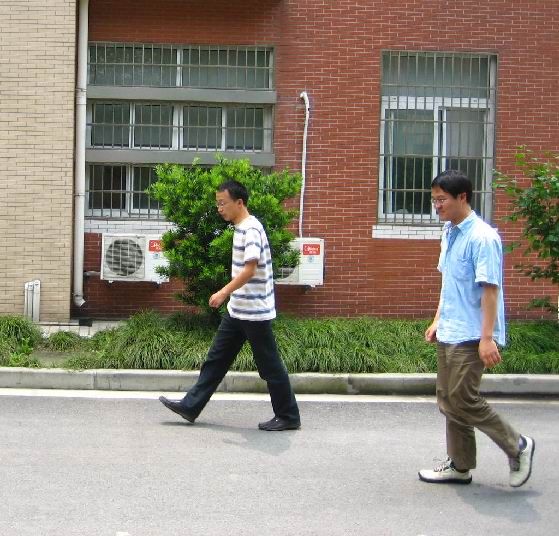

In [6]:
img

In [7]:
np.unique(mask)

array([0, 1, 2], dtype=uint8)

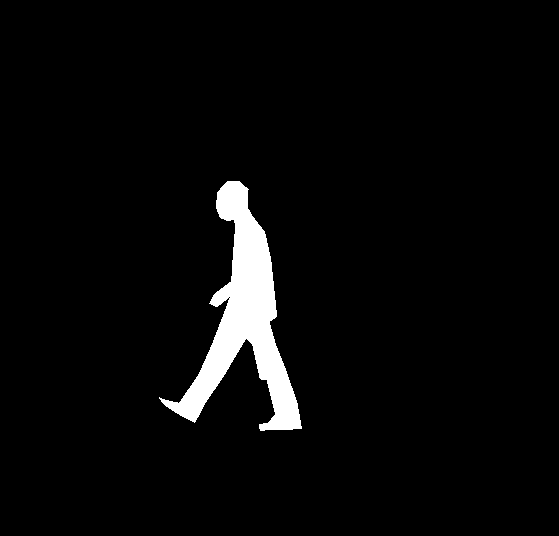

In [8]:
Image.fromarray(np.array(mask) == 1)

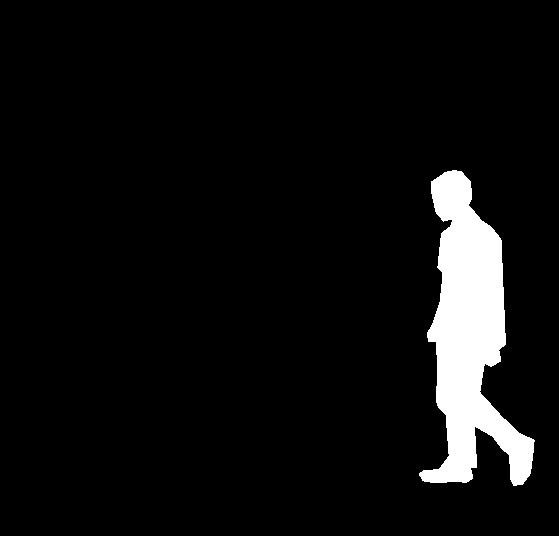

In [9]:
Image.fromarray(np.array(mask) == 2)

In [10]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)

In [11]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


In [12]:
transform = T.ToTensor()

In [13]:
def custom_collate(data):
  return data

In [14]:
images = sorted(os.listdir("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages"))
masks = sorted(os.listdir("/content/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks"))
num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [15]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [18]:
params = [p for p in model.parameters() if p.requires_grad]

In [19]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [20]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(30):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.7965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6961, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)}
0    82.28504556417465    5.837724030017853
1    52.52198454737663    5.648042261600494
2    41.59946459531784    3.861812114715576
3    35.052374109625816    3.6190294921398163
4    34.105230927467346    3.6400036215782166
5    30.398767113685608    3.1375173330307007
6    27.66148290038109    3.3059898912906647
7    26.96824449300766    2.9667753279209137
8    25.78215029835701    3.063262388110161
9    25.361004769802094    2.83366958796978
10    23.98372995853424    2.9299480319023132
11    23.850500777363777    3.0415530651807785
12    21.528594493

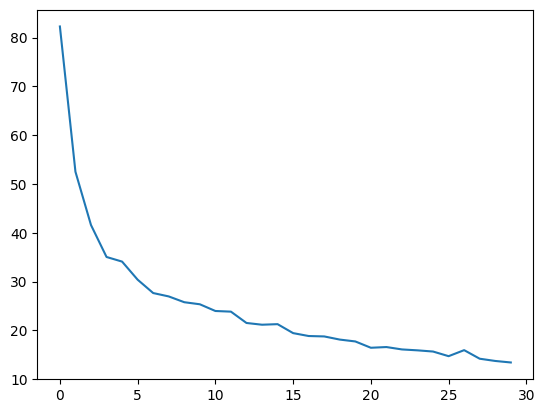

In [21]:
plt.plot(all_train_losses)

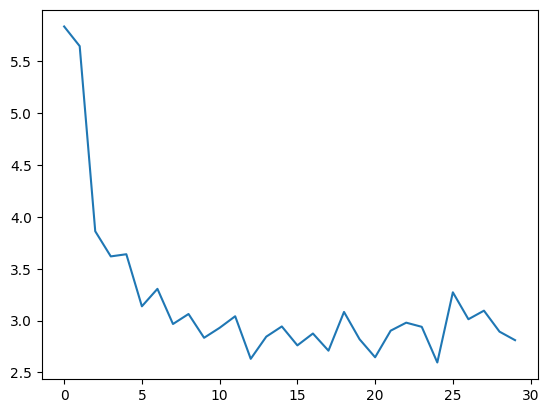

In [22]:
plt.plot(all_val_losses)

In [23]:
!wget https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg

--2025-03-11 10:29:37--  https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207783 (203K) [binary/octet-stream]
Saving to: ‘couple-3687274_960_720.jpg’

couple-3687274_960_ 100%[===================>] 202.91K  --.-KB/s    in 0.004s  

2025-03-11 10:29:37 (47.0 MB/s) - ‘couple-3687274_960_720.jpg’ saved [207783/207783]



In [24]:
model.eval()
img = Image.open("./couple-3687274_960_720.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

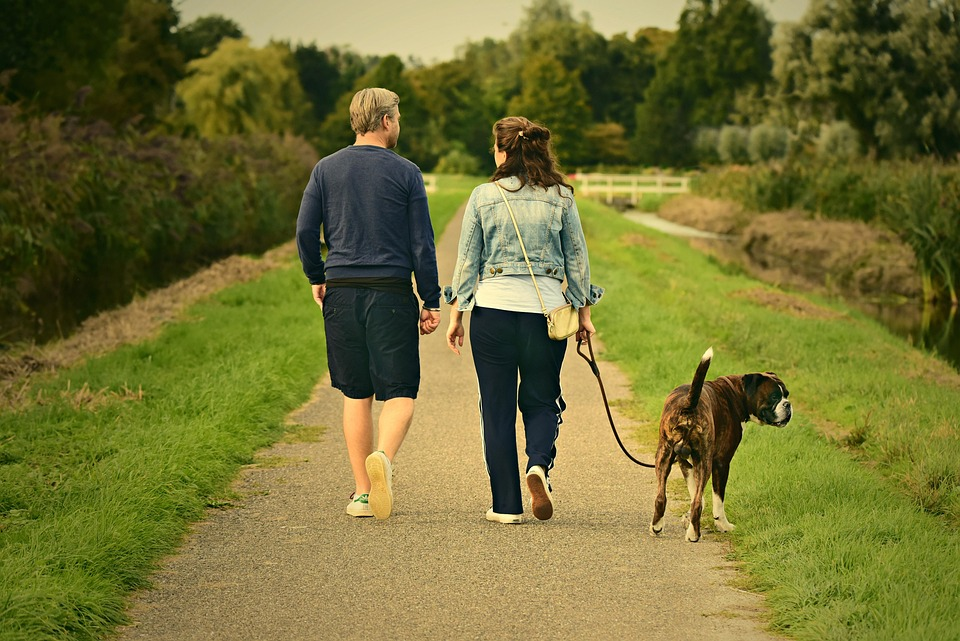

In [25]:
img

In [26]:
pred

[{'boxes': tensor([[288.3358,  82.1074, 444.7718, 518.3425],
          [438.1706, 113.5971, 598.6032, 521.7098],
          [650.6556, 382.4970, 723.2773, 534.8354],
          [319.3700, 102.5846, 701.5052, 508.9936],
          [238.5334,  92.8620, 546.4529, 506.8426]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9995, 0.9992, 0.4767, 0.3573, 0.0905], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]

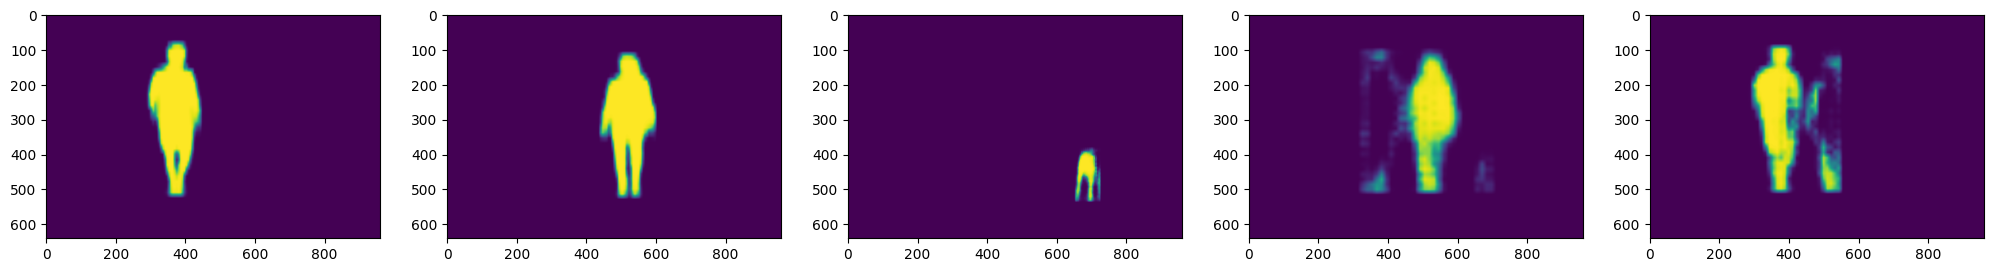

In [39]:
n_preds = len(pred[0]["masks"])
fig, ax = plt.subplots(1, n_preds, figsize=(5*n_preds,5))
for i in range(n_preds):
    ax[i].imshow((pred[0]["masks"][i].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [28]:
img.size

(960, 641)

In [41]:
all_preds = np.stack([(pred[0]["masks"][i].cpu().detach().numpy() * 255).astype("uint8").squeeze() for i in range(n_preds)])

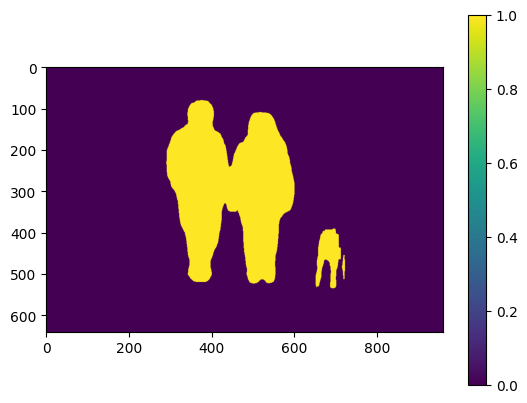

In [46]:
plt.imshow(all_preds.mean(axis = 0)>20)
plt.colorbar()